# Examining Relationships Between Lifestyle Habits and Academic Performance using Unsupervised Learning
# David Stanko, Aakash Krishna, Josh Wilkes

## Introduction

Understanding the relationship between study habits, health, and other cognitive factors has been a central focus in educational studies. In this project we used unsupervised learning to better understand and visualize these relationships. We are using the [Student Habits and Academic Performance Dataset](https://www.kaggle.com/datasets/aryan208/student-habits-and-academic-performance-dataset?resource=download) from Kaggle datasets [1]. It is a synthetic dataset containing features about students' lifestyle, backgrounds, habits, and academic performance. Some of the variables are the student's major, time spent studying, time spent on screens, mental health information, GPA, and exam scores. According to Kaggle, the goal of the dataset is explore how the last two variables are affected by the others.

The data was generated using Python, with realistic statistical and algorithmic techniques to mimic real student behavior. Some things to note was that the exam score was derived from the GPA and some noise. The GPA was "computed based on study hours, sleep, stress, motivation, support, and tutoring" [1].

We will perform principal component analysis (PCA), matrix factorization, k-means clustering, and hierarchical clustering on this dataset.

## Theoretical Background

**Principal Component Analysis (PCA):** PCA is a dimensionality reduction technique that identifies the directions in which the data varies most, then creates a new data set that is transformed under that new axis. This allows PCA to summarize complex, high-dimensional data into lower level data, aiding in computational efficiency. The principal components are a weighted combination of the original variance that have both scalar and vector properties.

**Singular Value Decomposition:** SVD is a matrix factorization that is very similar to PCA but it decomposes the data of matrix X into three matrices: X = USV. This decomposition allows to understand both the structure, direction, and magnitude of the predictors of the data.

**Matrix Completion:** Real world data often contains missing values. Our dataset also contains some missing data where a student may have forgotten to fill out a question or their response was not able to be determined. Matrix completion is a method for filling in these entries by assuming the data is approximately low-rank (explained by only a few predictors). This ensures that as much information as possible is kept before proceeding to clustering and visualization.

**K-means clustering:** K-means randomly partitions the data in to K-number of groups. And then iteratively selects a center point for each group and then re-assigns the groups to the center point until some threshold is met. This quickly groups the data in a high-level fashion.

**Hierarchical Clustering:** Unlike K-means, hierarchical clustering builds a tree dendrogram of clusters without needing to specify the number of groups. This works by initially clustering the data and then merging similar pairs together until they are all groups. Different linkage criteria exists such as complete, single, average, and Ward's linkage determine how distances between clusters are computed. Hierarchical clustering allows us to visualize the structure of different student groups.

## Methodology 

Our dataset had some continuous variables, some discrete numerical variables, and some categorical variables. First, we dropped all the categorical variables, because those are hard to interpret in the unsupervised methods we're using. We kept many of the discrete numerical variables. Many of them were integer ratings from 0-5 or 0-10. We kept those because a rating of 1.5, for example, is interpretable. Finally, we scaled the data to have zero mean and unit variance. The preprocessed data matrix had 16 features, including academic performance information, screen time, study habits, and mental health data.

Our models were as follows. First, we performed PCA on the preprocessed data. To see how well PCA approximates the data, we calculated and plotted the percent variance explained (PVE). To determine how many PCA components are needed for a good approximation, we calculated and plotted the cumulative PVE. We used PCA to obtain the importance of the variables, the correlations between them, and other information about the dataset. To quantify these, we looked at the matrix of principal component loadings, $\Phi$
, and the transformed data Z, 
, and we made various plots of the original and transformed data.

Matrix completion: To simulate missing data scenarios we pulled 20% of the data at random and then used low-rank matrix approximation using SVD to impute the missing values, we then compared the RMSE to different ranks to determine the optimal one.

K-means: we first found an appropriate number (k) of clusters we would separate our data into on the basis of their silhouette scores. After calculating this value, we performed our K-means function on a sample of our data and found its within-cluster sum of squares, also known as its inertia.

Afterwards, we decided to perform hierarchical clustering on the data. We performed this clustering three separate ways:

- Single Linkage, which uses the minimum distance between two points to cluster data.
- Complete Linkage, which uses the maximum distance between two points to cluster data.
- Average Linkage, which uses the average distance between two points to cluster data.

We then chose our complete linkage model to split into six clusters for a more accurate comparison to our K-means model, which we did by cutting our model tree at the appropriate length.

After comparing our different clusters to themselves and each other to identify common factors, we created a confusion matrix that directly compared our K-means to our hierarchical clustering model and found relatively different results across both methods.

## Imports

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.datasets import get_rdataset
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage

## Data preprocessing

### Examine the dataset

In [47]:
X = pd.read_csv("enhanced_student_habits_performance_dataset.csv")
X.head()

X_majors = X[['major']]

In [48]:
X.shape

(80000, 31)

In [49]:
is_null = pd.isnull(X) # boolean mask of same size as X for whether each value is null
[sum(is_null[i]) for i in X.columns] # see how many missing values there are in each column

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

The raw data has 80,000 rows and 31 columns. There are no missing values.

In [50]:
dtypes = X.dtypes # examine data types
dtypes

student_id                         int64
age                                int64
gender                            object
major                             object
study_hours_per_day              float64
social_media_hours               float64
netflix_hours                    float64
part_time_job                     object
attendance_percentage            float64
sleep_hours                      float64
diet_quality                      object
exercise_frequency                 int64
parental_education_level          object
internet_quality                  object
mental_health_rating             float64
extracurricular_participation     object
previous_gpa                     float64
semester                           int64
stress_level                     float64
dropout_risk                      object
social_activity                    int64
screen_time                      float64
study_environment                 object
access_to_tutoring                object
family_income_ra

We have many categorical variables encoded as strings (e.g.: gender, major, extracurricular_participation), so we have to drop those. However, let's examine all the columns of type `float64`. Some of the `int64` columns might be categorical or unnecessary as well. However, we know any column of type `float64` is continuous numerical data.

In [51]:
categorical_cols = dtypes[dtypes != "float64"].index # get the index of the dtypes series, where the value in the series is not float64
categorical_cols

Index(['student_id', 'age', 'gender', 'major', 'part_time_job', 'diet_quality',
       'exercise_frequency', 'parental_education_level', 'internet_quality',
       'extracurricular_participation', 'semester', 'dropout_risk',
       'social_activity', 'study_environment', 'access_to_tutoring',
       'family_income_range', 'parental_support_level', 'motivation_level',
       'exam_anxiety_score', 'learning_style', 'exam_score'],
      dtype='object')

In [52]:
# Look at the unique values of each non-float column

for col in categorical_cols:
    print(f"\n{'-'*50} {col} {'-'*50}")
    print(f"Unique values: {X[col].unique()}")


-------------------------------------------------- student_id --------------------------------------------------
Unique values: [100000 100001 100002 ... 179997 179998 179999]

-------------------------------------------------- age --------------------------------------------------
Unique values: [26 28 17 27 25 19 16 24 21 22 23 20 18]

-------------------------------------------------- gender --------------------------------------------------
Unique values: ['Male' 'Other' 'Female']

-------------------------------------------------- major --------------------------------------------------
Unique values: ['Computer Science' 'Arts' 'Psychology' 'Business' 'Engineering' 'Biology']

-------------------------------------------------- part_time_job --------------------------------------------------
Unique values: ['Yes' 'No']

-------------------------------------------------- diet_quality --------------------------------------------------
Unique values: ['Poor' 'Good' 'Fair']

---------

Based on context and what the variables represent, we should drop `student_id`, `gender`, `major`, `part_time_job`, `diet_quality`, `parental_education_level`, `internet_quality`, `extracurricular_participation`, `semester`,
                      `dropout_risk`, `study_environment`, `access_to_tutoring`,
                      `family_income_range`, and `learning_style`. We have some variables on a scale of 0-10 or 0-5, like `exercise_frequency` and `social_activity`. Even though those are discrete numerical variables, we think we should keep them because an exercise or social activity frequency of 1.5, for example, is meaningful and interpretable. Ratings like that do not have to be integers.

### Drop categorical variables and other irrelevant variables:

In [53]:
X = X.drop(columns = ["student_id", "gender", "major", "part_time_job",
                      "diet_quality", "exercise_frequency", "parental_education_level",
                      "internet_quality", "extracurricular_participation", "semester",
                      "dropout_risk", "study_environment", "access_to_tutoring",
                      "family_income_range", "learning_style"])

In [54]:
X.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,mental_health_rating,previous_gpa,stress_level,social_activity,screen_time,parental_support_level,motivation_level,exam_anxiety_score,time_management_score,exam_score
0,26,7.645367,3.0,0.1,70.3,6.2,6.0,4.00,5.8,0,10.9,9,7,8,3.0,100
1,28,5.700000,0.5,0.4,88.4,7.2,6.8,4.00,5.8,5,8.3,7,2,10,6.0,99
2,17,2.400000,4.2,0.7,82.1,9.2,5.7,3.79,8.0,5,8.0,3,9,6,7.6,98
3,27,3.400000,4.6,2.3,79.3,4.2,8.5,4.00,4.6,3,11.7,5,3,10,3.2,100
4,25,4.700000,0.8,2.7,62.9,6.5,9.2,4.00,5.7,2,9.4,9,1,10,7.1,98


### Scale the data

We will now scale the data to have zero mean and unit variance.

In [55]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns) # scaled dataset
X_scaled.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,mental_health_rating,previous_gpa,stress_level,social_activity,screen_time,parental_support_level,motivation_level,exam_anxiety_score,time_management_score,exam_score
0,1.066790,1.731919,0.344972,-1.641677,0.019161,-0.557064,-0.418464,0.858879,0.403204,-1.467026,0.441221,1.225264,0.527057,-0.283052,-0.959906,0.936783
1,1.600758,0.761237,-1.384614,-1.382158,1.063417,0.124429,-0.002138,0.858879,0.403204,1.466762,-0.493744,0.529203,-1.216462,0.830286,0.192381,0.850512
2,-1.336063,-0.885369,1.175173,-1.122639,0.699947,1.487414,-0.574587,0.405191,1.529583,1.466762,-0.601625,-0.862921,1.224465,-1.396390,0.806934,0.764242
3,1.333774,-0.386398,1.451907,0.261462,0.538405,-1.920049,0.882557,0.858879,-0.211185,0.293247,0.728903,-0.166859,-0.867758,0.830286,-0.883087,0.936783
4,0.799807,0.262265,-1.177064,0.607487,-0.407773,-0.352616,1.246843,0.858879,0.352005,-0.293511,-0.098182,1.225264,-1.565166,0.830286,0.614886,0.764242


# Results and Discussion

## PCA/SVD

Now, we will perform PCA on the scaled dataset and interpret the results.

In [56]:
pca = PCA(random_state=42)
pca_out = pca.fit_transform(X_scaled) # transformed values of X_scaled of shape (n_samples, n_components)

`pca.components_` are the "principal axes in feature space, representing the directions of maximum variance in the data" [2]. `pca.components_` is a matrix where each row is a principal component and each column is a feature of the original data. `pca_out` has shape `(n_components, n_features)`, and it's equivalent to the $\Phi$ matrix in PCA.

In [57]:
pca.components_.shape

(16, 16)

In [58]:
# Make a dataframe for the phi matrix with the principal components as columns, where a row corresponds to each feature
principal_components = pd.DataFrame(pca.components_.T,
             index = X_scaled.columns,
             columns = [f"PC{i}" for i in range(1, 17)])

In [59]:
abs_ = lambda series: abs(series) # Lambda function for taking the absolute value of each element in a series. We use this to sort by magnitude of PCs

# Show just the first 2 PCs, sorted by the first one in order of importance.
# Use the key parameter to apply the function to the values before sorting.
pc_sorted = principal_components.sort_values(by = "PC1", ascending=False, key = abs_)[["PC1", "PC2"]] 

pc_sorted

,PC1,PC2
previous_gpa,0.512138,-0.029378
exam_score,0.502559,-0.027323
motivation_level,0.385541,-0.401876
exam_anxiety_score,-0.379563,0.401580
study_hours_per_day,0.291250,0.419916
screen_time,0.290528,0.582071
social_media_hours,0.088989,0.313666
stress_level,-0.079583,0.006366
netflix_hours,0.070879,0.248817
sleep_hours,0.060247,-0.006692


Now we will look at `pca_out`, an 80,000 x 16 matrix containing the transformed data. This matrix is equivalent to $Z$ from PCA. A few cells below, we will interpret both the loading matrix $\Phi$ above and the $Z$ matrix below.

In [60]:
pca_out.shape

(80000, 16)

In [61]:
Z = pd.DataFrame(pca_out, columns=[f"Z{i}" for i in range(1, 17)]) # Display Z as a dataframe
Z.head()

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16
0,1.684668,0.311374,0.350229,-1.191045,-1.258268,-1.731625,0.017022,-1.579029,1.229602,-0.496805,0.756653,0.548420,-0.278063,0.160494,-0.073230,-0.224908
1,-0.088348,0.019860,2.403694,-1.061686,-0.499833,0.492236,1.611704,0.626763,1.712171,-0.229468,0.359141,0.988649,0.130205,-0.282309,0.027847,0.192574
2,1.158806,-1.713289,-0.793184,-1.158124,-0.996437,1.651960,0.706184,0.145965,-1.231867,2.068084,-1.281590,0.360920,0.738019,-0.136399,-0.252612,-0.065107
3,0.414767,1.417593,0.492714,1.020086,-1.158573,-0.155107,0.841341,-0.251903,1.005046,-1.192761,0.165911,-1.332203,1.880957,-0.048267,-0.012011,0.095153
4,-0.147260,0.756487,1.876456,0.240322,1.297129,-0.484135,-0.368718,0.198578,1.173514,-0.209992,0.934932,0.657784,1.256560,-0.529327,0.112459,0.056877


### Interpretation of $\Phi$ and Z

**Specific Criteria Question 2:**

**Discussion: In the context of your data, how can the U and V\* matrix from the SVD (or "x" and "rotation" from PCA) be interpreted?**

#### Interpretation of $\Phi$

The way we are using PCA in sklearn does not have an `x` or `rotation` matrix. However, U from SVD is equivalent to Z from PCA, and V from SVD is equivalent to $\Phi$ from PCA.

**Interpretation of $\Phi$, the loading matrix above:**

The most important features in `X_scaled` are `previous_gpa` and `exam_score`, because they have the highest magnitude loadings. However, recall that GPA was computed based on some other features, and that `exam_score` was computed from GPA. So, because `exam_score` and `previous_gpa` are calculated based on many other features, it makes sense that they are important, because they summarize a lot of the dataset.

The 6 most important features are (in descending order of importance):

- `previous_gpa`
- `exam_score`
- `motivation_level`
- `exam_anxiety_score`
- `study_hours_per_day`
- `screen_time`

$\Phi$ tells us which features are positively or negatively correlated, and the strength of the correlations. `exam_anxiety_score` has a negative loading, and the other features mentioned above have positive loadings. So, `exam_anxiety_score` is negatively correlated with the other 5 features above. That means:

- Students with a high `previous_gpa` have a low `exam_anxiety_score`. 
    - That makes sense because, if a student already has a high GPA, performing badly on future exams will not affect their GPA much. So, they won't be as anxious about exams.
    - Based on the coefficients, there is a fairly strong negative linear correlation

- Students with a high `exam_score` have a low `exam_anxiety_score`. 
    - That makes sense because, if these students already perform well on exams, they're less anxious about future exams.
    - The correlation between the variables is about as strong as for `previous_gpa`

- Students with a high `exam_anxiety_score` have a low `motivation_level`. 
    - So, if students are anxious about exams, they are less motivated to do well in school. This was a surprising result because we would expect that exam anxiety motivates students to perform better.
    - The variables are very strongly negatively correlated, because the loadings are approximately -0.38 and 0.39, respectively.

- Students who studied for more hours per day had a lower `exam_anxiety_score`, which makes sense
    - The correlation is strong, but not as strong as the one between `exam_anxiety_score` and `motivation_level`

- Surprisingly, students with a high `screen_time` had a *low* `exam_anxiety_score`. 
    - We would expect the opposite to be true because screen time can negatively affect academic performance. However, more screen time helped students have less exam anxiety. Perhaps that's because screen time is a way to relax. 
    - `screen_time` is approximately as correlated with `exam_anxiety_score` as `study_hours` is.

Some features that are *not* important are `time_management_score`, `attendance_percentage`, `age`, `social_activity`, and `parental_support_level`. 

$\Phi$ also tells about the features that are *positively* correlated with each other in `X_scaled`:

-  `previous_gpa` and `exam_score` are positively correlated because both of their respective loadings are positive. They are strongly correlated because they're very close in magnitude. That makes perfect sense because, in the original dataset, `exam_score` was computed using GPA
- `exam_score` and `motivation_level` are positively correlated, but the correlation is not as strong, because the magnitudes are less close.
- `exam_score` and `study_hours_per_day` are positively correlated, but less so than for the variables above.
- `exam_score` and `screen_time` are positively correlated

Let's make a few plots to illustrate these correlations and how they are shown in the principal component loadings. Because there are 80,000 observations, we will do subsampling and randomly select 5,000 observations to plot.

In [62]:
np.random.seed(42)

random_indices = np.random.choice(80000, size=5000, replace=False) # get indices of the rows to randomly select
Z_sample = pca_out[random_indices] # the selected rows of the Z matrix
X_sample = X_scaled.loc[random_indices, :].reset_index(drop=True) # the selected rows of the X matrix

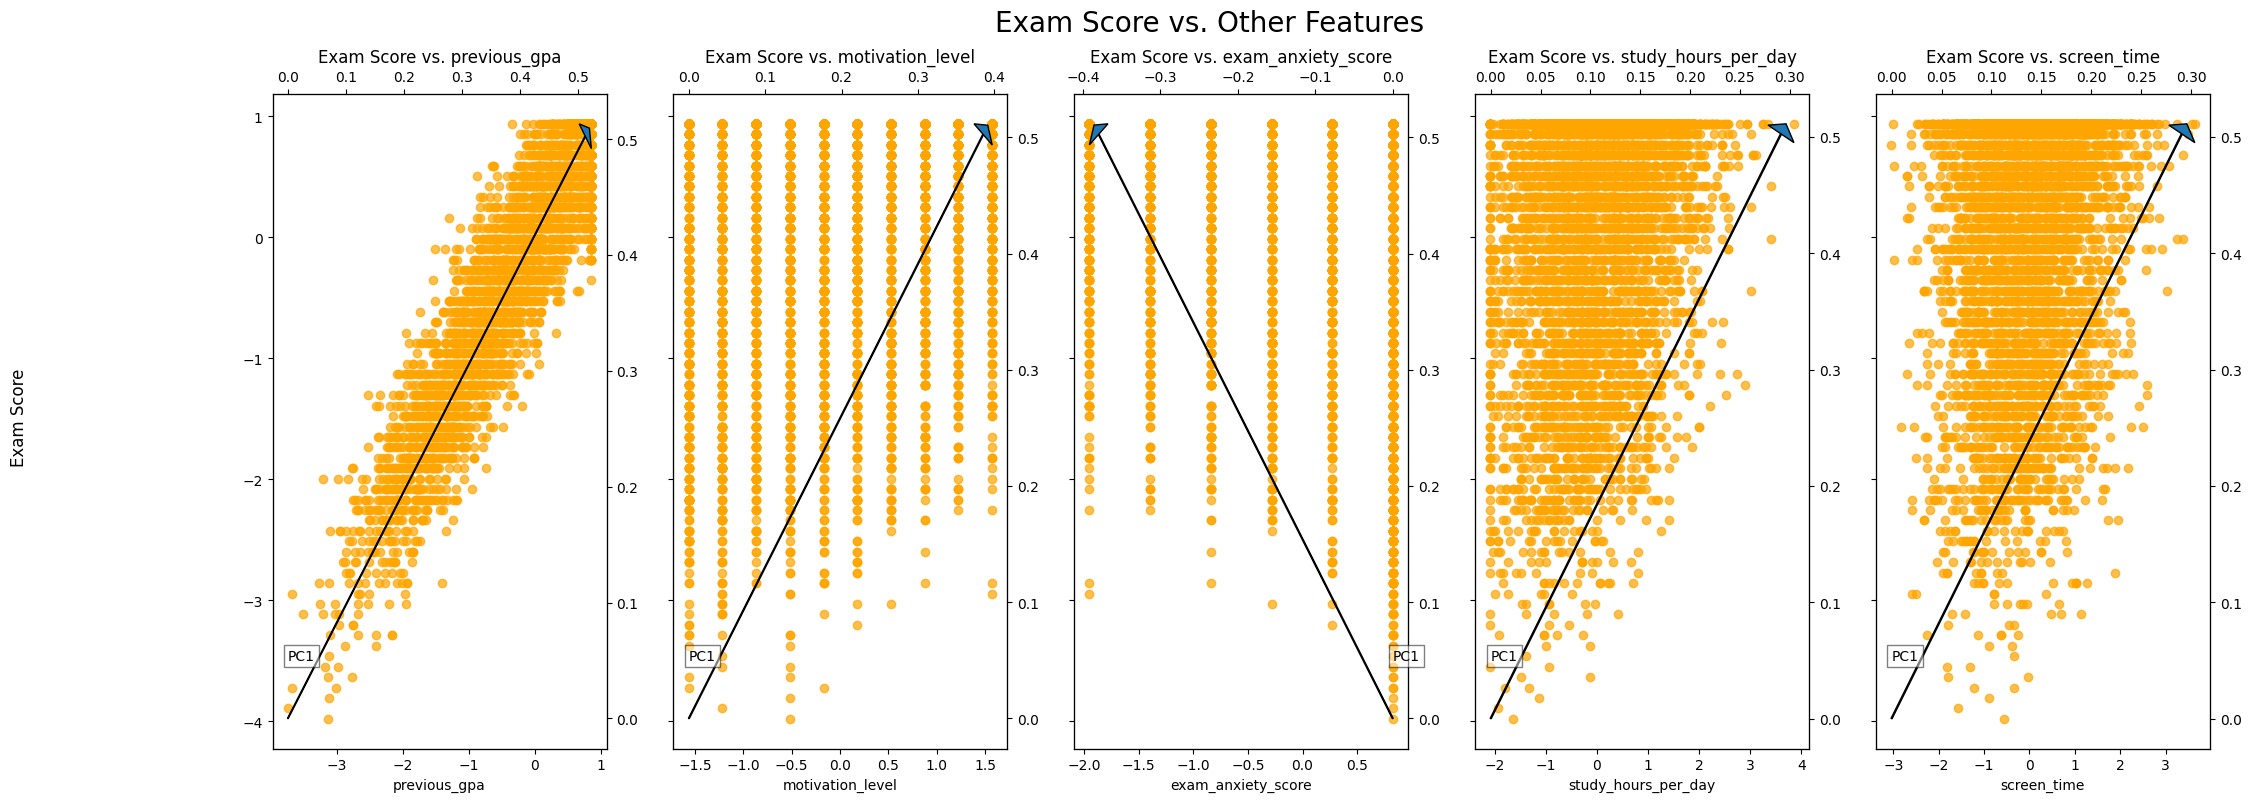

In [63]:
fig, axs = plt.subplots(1, 5, sharey=True)
fig.set_size_inches(25, 8.5)
fig.supylabel("Exam Score")
fig.suptitle("Exam Score vs. Other Features", fontsize=20)

for i, feature in enumerate(["previous_gpa", "motivation_level", "exam_anxiety_score", "study_hours_per_day", "screen_time"]):
    axs[i].scatter(X_sample[feature], X_sample["exam_score"], alpha=0.7, c="orange")
    axs[i].set_xlabel(feature)
    axs[i].set_title(f"Exam Score vs. {feature}")

    # make twin axes to plot PC1 loading vector
    ax2 = axs[i].twinx().twiny() 

    # Plot an arrow with the two components of PC1 that correspond to these two features. Label it as PC1
    ax2.arrow(0, 0, pc_sorted.loc[feature, "PC1"], pc_sorted.loc["exam_score", "PC1"], head_width=0.03, head_length=0.01)
    ax2.text(0, 0.1 *pc_sorted.loc["exam_score", "PC1"] , "PC1", bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 3})


The plots above show `exam_score` vs. several other features in the X matrix. Each plot shows an arrow in the direction of the components of PC1 for *just* those two features. 

The scatter plot proves all the correlations we found in $\Phi$. For instance, $\Phi$ indicated that exam score and GPA were strongly positively correlated, and the leftmost scatter plot shows exactly that. $\Phi$ also showed that `exam_score` and `exam_anxiety_score` are negatively correlated, and that the correlation is not as strong. That's reflected in the plot too. The same can be said for the other three features.

Also, notice that the arrows for PC1 seem to be located in the direction of greatest variance of the data. For instance, for `exam_score` vs. `previous_gpa`, PC1 has an upward slope that matches the direction of greatest variance, which is upward. 

#### Interpretation of Z

Each row of the original data matrix (`X_scaled` in our code) represents a unique student, out of 80,000 total students. So, each row of $Z$ represents where each student lies in the transformed space. In other words, row $i$ of $Z$ is where student $i$ in the `X_scaled` matrix lies in the principal component space. $Z$ represents where the students lie in the space that captures the highest variance in the data (that is, ordered from highest variance to lowest variance). 

To further interpret Z and how the transformed data captures the trends seen in $\Phi$, we will consider the plots below. 

In [64]:
# Find a student with a low exam score and one with a high exam score, to highlight that student in the X and Z plots
X_sample.loc[(X_sample["exam_score"] < -3) | (X_sample["exam_score"] > 0.9), ["exam_score", "study_hours_per_day"]].sort_values(by=["exam_score", "study_hours_per_day"], ascending=True)

,exam_score,study_hours_per_day
3127,-3.980645,-1.633826
3754,-3.894375,-1.933209
4081,-3.808104,-1.134855
1279,-3.721833,-1.791961
1010,-3.721833,-1.334444
...,...,...
408,0.936783,2.940565
3684,0.936783,3.256058
725,0.936783,3.256094
3202,0.936783,3.355889


The student at index 3754 has a low exam score and a low `study_hours_per_day`. We'll plot that student with a red dot. The student at index 597 has a high exam score and a high `study_hours_per_day`. We'll plot that student with a black dot.

In [65]:
low_index = 3754
high_index = 597

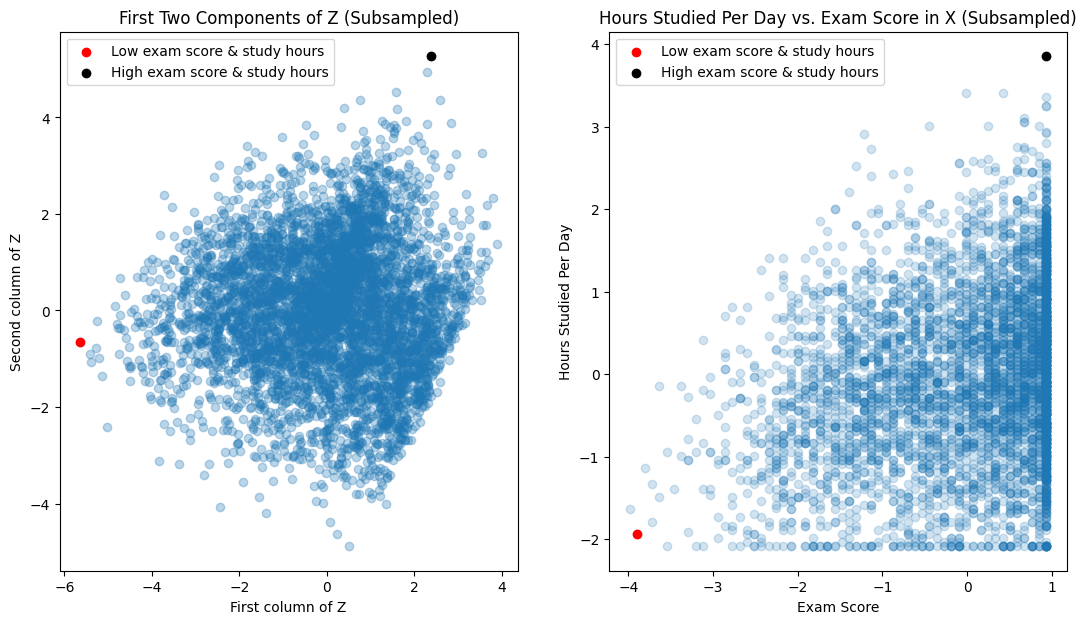

In [66]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((13, 7))

# Plot the data in the transformed space (Z)
axs[0].scatter(Z_sample[:, 0], Z_sample[:, 1], alpha = 0.3)

axs[0].scatter(Z_sample[low_index, 0], Z_sample[low_index, 1], c = "red", label = "Low exam score & study hours",)
axs[0].scatter(Z_sample[high_index, 0], Z_sample[high_index, 1], c = "black", label = "High exam score & study hours")

axs[0].set_xlabel("First column of Z")
axs[0].set_ylabel("Second column of Z")
axs[0].set_title("First Two Components of Z (Subsampled)")
axs[0].legend()

# Exam anxiety score vs. motivation level in X
axs[1].scatter(X_sample["exam_score"], X_sample["study_hours_per_day"], alpha=0.2)

axs[1].scatter(X_sample.loc[low_index, "exam_score"], X_sample.loc[low_index, "study_hours_per_day"], c = "red", label = "Low exam score & study hours")
axs[1].scatter(X_sample.loc[high_index, "exam_score"], X_sample.loc[high_index, "study_hours_per_day"], c = "black", label = "High exam score & study hours")

axs[1].set_xlabel("Exam Score")
axs[1].set_ylabel("Hours Studied Per Day")
axs[1].set_title("Hours Studied Per Day vs. Exam Score in X (Subsampled)")
axs[1].legend()

plt.show()

In both $X$ and $Z$, the student with the red dot is still located far away from the student with the black dot. The student with the red dot  still has lower values of both PC1 and PC2 than the student with the black dot. That means $Z$ preserves the relationship between hours studied per day and exam score. That makes sense because these two variables are in the top 5 most important variables.

### Scree Plot

In [67]:
pve = pca.explained_variance_ratio_ # proportion of variance explained by each principal component
pve

array([0.16173982, 0.1222292 , 0.08939663, 0.0687587 , 0.06323569,
       0.06290213, 0.06264529, 0.06262927, 0.06240772, 0.0620661 ,
       0.06202574, 0.05719965, 0.05204963, 0.00519115, 0.00415874,
       0.00136455])

In [68]:
pve_cumulative = np.cumsum(pve) # Cumulative PVE
pve_cumulative

array([0.16173982, 0.28396902, 0.37336564, 0.44212434, 0.50536004,
       0.56826217, 0.63090746, 0.69353673, 0.75594445, 0.81801055,
       0.88003629, 0.93723594, 0.98928557, 0.99447672, 0.99863545,
       1.        ])

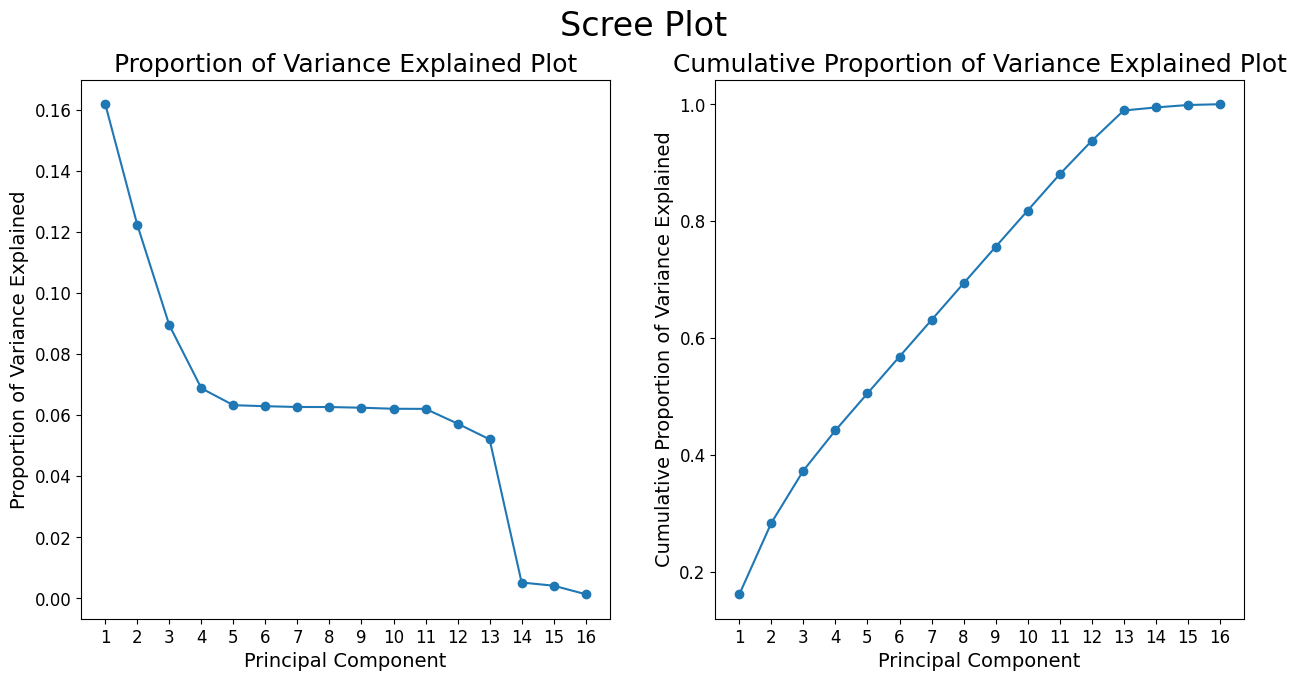

In [69]:
# Make a scree plot
indices = np.arange(1, 17) # indices for the components from 1 to n_components

fig, axs = plt.subplots(nrows=1, ncols=2)

# Set axis label font size to 12
axs[0].tick_params(axis="both", labelsize=12)
axs[1].tick_params(axis="both", labelsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.set_size_inches(15, 7)
fig.suptitle("Scree Plot", fontsize=24)

# PVE plot
axs[0].plot(indices, pve, marker = 'o')
axs[0].set_ylabel("Proportion of Variance Explained", fontsize=14)
axs[0].set_xlabel("Principal Component", fontsize=14)
axs[0].set_title("Proportion of Variance Explained Plot", fontsize=18)
axs[0].set_xticks(indices)

# Cumulative PVE plot
axs[1].plot(indices, pve_cumulative, marker='o')
axs[1].set_ylabel("Cumulative Proportion of Variance Explained", fontsize=14)
axs[1].set_xlabel("Principal Component", fontsize=14)
axs[1].set_title("Cumulative Proportion of Variance Explained Plot", fontsize=18)
axs[1].set_xticks(indices)

plt.show()

**Specific Criteria Question 1:** 

**Plot: the scree plot/proportion of variance explained plot that results from your data. Discuss what the shape of it means about the decomposition.**

The `pve` array shows that the first principal component explains only 16.2% of the data. So, PCA is not a good approximation of this data. If PCA *were* a good approximation of the data, the first component would explain much more of the variance, and then the plot would drastically decrease. But, here, there is not one principal component that captures a lot of the variance in the data. Instead, the variance in the data is spread out among all the principal components. 

Looking at the cumulative PVE plot and the `pve_cumulative` variable, we believe it takes 10 principal components to approximate the data well, because that gives us a PVE of 81.8%.

Also, the cumulative PVE curve increases the most rapidly from principal components M = 1 to M = 3. That means that components 1-3 explain a lot of variance compared to the other components, when we look at *just* individual principal components. Then, the plot begins increasing at a roughly constant rate from M = 3 to M = 13. So, the individual components 4-13 explain roughly the same amount of variance. Then, the plot very slowly increases from M = 13 to 16. At M = 13, the cumulative PVE is 98.9%. So, components 14-16 play almost no role in approximating the data well. Therefore, if we needed a *very accurate* approximation of the data, 13 components are sufficient because we can get a cumulative PVE of over 98%. We don't need all 16 components to be accurate. It is very useful in terms of computational efficiency that we can remove 3 principal components and still achieve a cumulative PVE of almost 100%. 

### Comparing the original and transformed data

Now we will plot the first two features of the transformed data, $Z$. $Z_{im}$ is the location of the i-th data point in the transformed space. We use subsampling with the same randomly selected points.

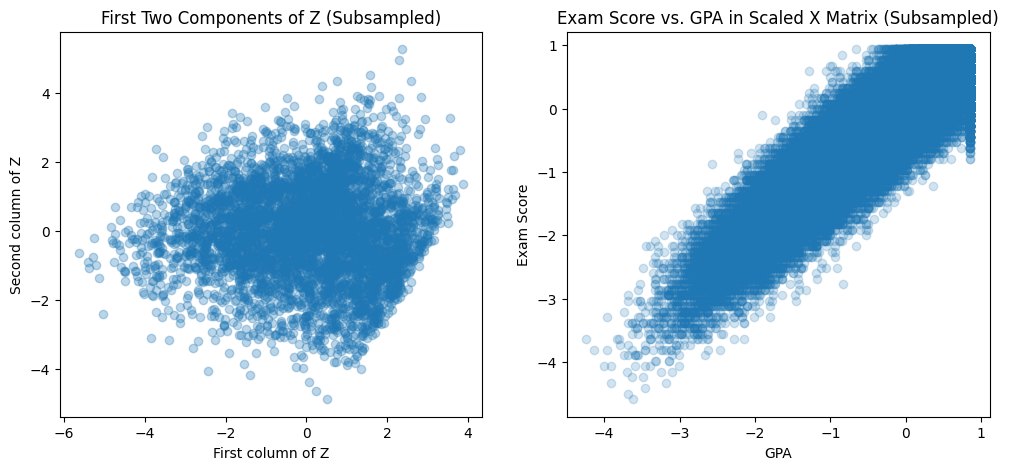

In [70]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((12, 5))

# Plot the data in the transformed space (Z)
axs[0].scatter(Z_sample[:, 0], Z_sample[:, 1], alpha = 0.3)

axs[0].set_xlabel("First column of Z")
axs[0].set_ylabel("Second column of Z")
axs[0].set_title("First Two Components of Z (Subsampled)")

# Plot two features of the original X matrix to compare
axs[1].scatter(X_scaled["previous_gpa"], X_scaled["exam_score"], alpha=0.2)
axs[1].set_xlabel("GPA")
axs[1].set_ylabel("Exam Score")
axs[1].set_title("Exam Score vs. GPA in Scaled X Matrix (Subsampled)")
plt.show()

The code below compares the correlation coefficient matrix between the first two columns of Z, and the corr. coef. matrix between `previous_gpa` and `exam_score` in X.

In [71]:
np.corrcoef(Z_sample[:, 0], Z_sample[:, 1])

array([[1.        , 0.02450572],
       [0.02450572, 1.        ]])

In [72]:
np.corrcoef(X_sample.loc[:, "previous_gpa"], X_sample.loc[:, "exam_score"])

array([[1.        , 0.93593277],
       [0.93593277, 1.        ]])

**Discussion question: Plot the data in the first two principal components. What, if any, structure exists inherently within the data? How does this differ from plotting on two original features?**

Looking at just the plots, the plot of the original data ($X$) is much more linear than the plot of the transformed data ($Z$). We confirmed this using the correlation coefficient. The correlation coefficient between the first two columns of $Z$ is 0.0014, while the correlation coefficient for the original data is 0.93. That means we have a very strong positive correlation between the two plotted features in $X$ (as we saw before), but basically no correlation between the first two components of the transformed data.

The first two principal components are not nearly as correlated with each other as those two features in $X$. The loading vectors tell us that `exam_score` and `previous_gpa` are the two most important features in the data by far. However, doing PCA reduces the correlation between the first two principal components to basically zero. 

This makes sense when we look at the loading vectors. The loading vectors of PC1 and PC2 are shown again below, but this time sorted by the values of PC2. The loadings of `exam_score` and `previous_gpa` in the *second principal component* are about -0.03. That's low in magnitude compared to the highest-magnitude loadings for PC2. So, those features are not an important part of PC2. 

However, `screen_time`, `study_hours_per_day`, and `exam_anxiety_score` are the most important features of PC2, as indicated by the loadings below. And PC1 has `exam_score` and `previous_gpa` as important features. That means that, if the $Z$ plot shows little correlation, there's little correlation between the `exam_score` and `previous_gpa` features and the `screen_time`, `study_hours_per_day`, and `exam_anxiety_score` features, respectively. 

So, screen time, hours studied, and exam anxiety score do not have much of an effect on exam score and GPA.

In [73]:
principal_components.sort_values(by = "PC2", ascending=False)[["PC1", "PC2"]]

,PC1,PC2
screen_time,0.290528,0.582071
study_hours_per_day,0.291250,0.419916
exam_anxiety_score,-0.379563,0.401580
social_media_hours,0.088989,0.313666
netflix_hours,0.070879,0.248817
stress_level,-0.079583,0.006366
attendance_percentage,0.004312,0.005182
time_management_score,0.007481,0.003612
mental_health_rating,0.012954,0.002225
parental_support_level,-0.006836,0.000807


## Matrix Completion

First, we will introduce missing elements into the array in order to check the efficacy of the matrix completion later

In [74]:
np.random.seed(21)
X = X_scaled.to_numpy(copy=True)
missing_elements = int(X.shape[0] * 0.2)

row_index = np.random.choice(X.shape[0], size=missing_elements, replace=False)
column_index = np.random.choice(X.shape[1], size=missing_elements)

Xna = X.copy()
Xna[row_index, column_index] = np.nan


In [75]:
def fit_svd(X, M=1):
    U, s, V = np.linalg.svd(X,full_matrices=False)
    return U[:, :M] @ (np.diag(s[:M]) @ V[:M, :]) 

Then, we create a function that will return a completed matrix. In this function we initialize variables that will replace the missing values with column means and other variables that will be used to track the progress of the iterations that will be used to fit our data. A while loop is formed that will track and iterate fittings of matrix completions using SVD until the relative error becomes better then the threshold value we created earlier

In [76]:
def matrix_completion(X_na, rank=5, max_iter=100, thresh=1e-7):
    X_filled = X_na.copy()
    
    rel_err = 1
    iter_ = 0
    Xhat = Xna.copy()
    xbar = np.nanmean(Xna, axis=0)
    Xhat[row_index, column_index] = xbar[column_index]
    for r, c in zip(row_index, column_index):
        Xhat[r, c] = xbar[c]




    ismiss = np.isnan(Xna)
    Xscaled = (Xna - xbar) / np.sqrt(np.sum(~ismiss, axis=0))
    Xscaled_nomiss = Xscaled[~ismiss]
    mssold = np.mean(np.square(Xscaled_nomiss))
    mss0 = np.mean(np.square(Xna[~ismiss]))

    while rel_err > thresh:
        iter_ += 1
        Xapp = fit_svd(Xhat, M=1)
        Xhat[ismiss] = Xapp[ismiss]
        mss = np.mean(np.square(Xna[~ismiss] - Xapp[~ismiss]))
        rel_err = (mssold - mss) / mss0
        mssold = mss
    
    print(f"Iter: {iter_}, MSS: {mss}, Rel. Err: {rel_err}")
   

    return X_filled

Iter: 1, MSS: 0.8381578577434508, Rel. Err: -0.8381940562743331


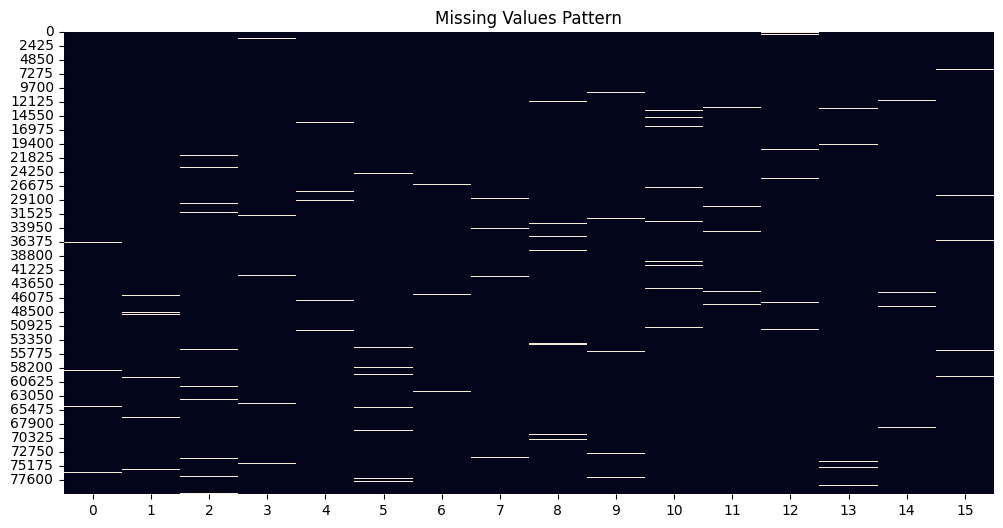

Figure 1: Missing values in data set pre-SVD


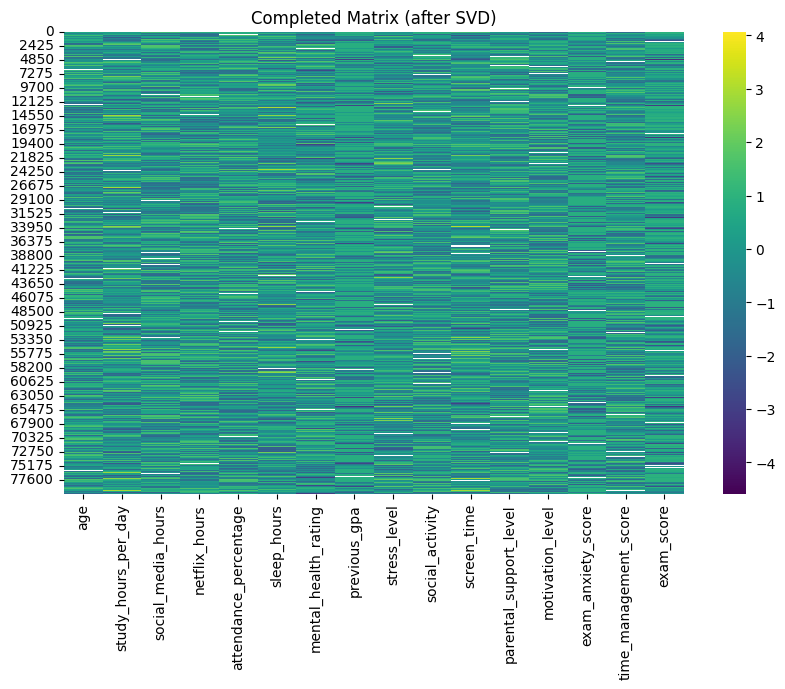

Figure 2: 


In [77]:
X_completed = matrix_completion(Xna, rank=5)

# Convert back to DataFrame for interpretation
X_completed_df = pd.DataFrame(X_completed, columns=X_scaled.columns)

# Compare histograms or heatmaps before and after
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(pd.DataFrame(Xna).isna(), cbar=False)
plt.title("Missing Values Pattern")
plt.show()
print("Figure 1: Missing values in data set pre-SVD")

plt.figure(figsize=(10, 6))
sns.heatmap(X_completed_df, cmap="viridis")
plt.title("Completed Matrix (after SVD)")
plt.show()
print("Figure 2: ")


Looking at the distribution of missing values in this code we see even distribution of dropped values in figure 1 and very few to know white values in figure 2 showing the low-level matrix completion was successful. In the next figure we will analyze its performance.

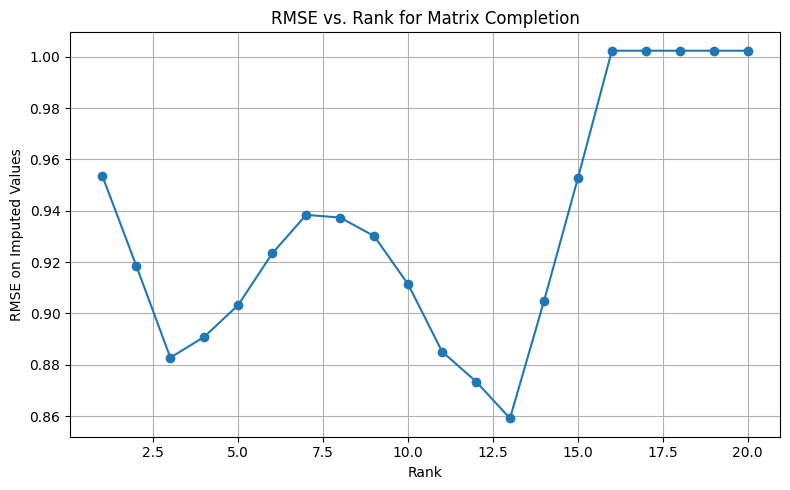

In [78]:
ranks = list(range(1, 21))
rmse_values = []


true_vals = X[row_index, column_index]

for r in ranks:
    Xhat = Xna.copy()
    xbar = np.nanmean(Xna, axis=0)
    for rr, cc in zip(row_index, column_index):
        Xhat[rr, cc] = xbar[cc]

    U, s, Vt = np.linalg.svd(Xhat, full_matrices=False)
    S = np.diag(s[:r])
    Xapp = U[:, :r] @ S @ Vt[:r, :]

    pred_vals = Xapp[row_index, column_index]

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
    rmse_values.append(rmse)

# Plot RMSE vs Rank
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ranks, rmse_values, marker='o')
plt.title("RMSE vs. Rank for Matrix Completion")
plt.xlabel("Rank")
plt.ylabel("RMSE on Imputed Values")
plt.grid(True)
plt.tight_layout()
plt.show()


When computing the RMSE vs. rank we see that the lowest RMSE is 13. The MSS of this graph was also 0.838157. The RMSE drops quickly at low ranks, suggesting that a very low-rank approximation captures substantial structure in the data. This supports the hypothesis that student behaviors may be governed by a few latent factors. RMSE then fluctuates but reaches its minimum around rank 13. This suggests that 13 components provide the best balance between model complexity and reconstruction accuracy. 

## K-Means

Our first goal is to find the best number of clusters for us to use. We will determine the best number using a short loop that looks at silhouette scores with different numbers of clusters, measuring how clearly defined the clusters are. We will calculate this number, k, as the number of clusters that gives us a low enough silhouette score. We are using a sample of 50 different data points to compare our K-Means and Hierarchical models, as higher numbers make it hard to read our hierarchical models.

In [79]:

np.random.seed(21)
X_samp = X_scaled.sample(n=50)

def compute_k_sil(k):
   kmeansk = KMeans(n_clusters=k, random_state=3, n_init=20).fit(X_samp);
   labels = kmeansk.labels_
   silscore = metrics.silhouette_score(X_samp, labels, metric='euclidean')
   return silscore

kvals = np.arange(2,13)
silvals = [compute_k_sil(kval) for kval in kvals]

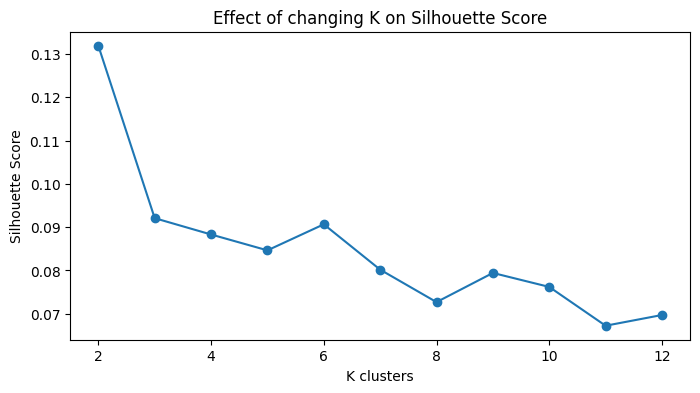

In [80]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(kvals, silvals, linestyle='-', marker='o')
ax.set_xlabel('K clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title("Effect of changing K on Silhouette Score");

From this graph, we can conclude that 6 clusters is a good number to use as it accounts for a majority of the differences between classes and is not too large. After the small spike at 6 clusters, the line graph begins to fall and never quite reaches the same height.

In [81]:
kmeans_s = KMeans(n_clusters=6,
                  random_state=5,
                  n_init=50).fit(X_samp);

kmeans_s.inertia_

490.28485875636164

After running our KMeans model on the observed best number of clusters, we observe a within-cluster sum of squares of roughly 490.28.

### Specific criteria 4 (part 1)

Question: Plot/Discussion: After clustering, which observations belong to the same cluster? Look at the underlying data and see what might be similar between them, and how these differ from observations in other clusters. How can the groups be interpreted?

We will answer this question for K-means clustering now, and later, we will answer it for hierarchical clustering.

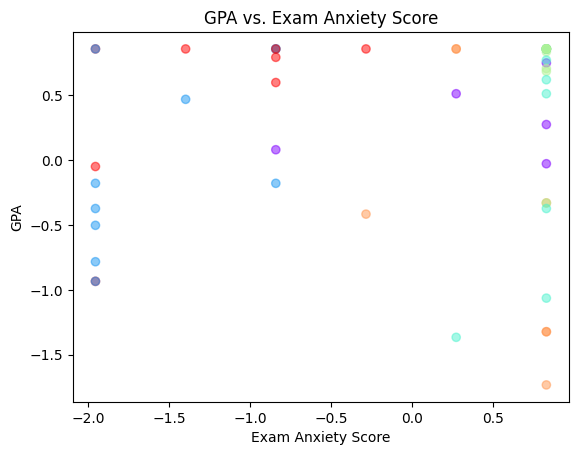

In [82]:
plt.scatter(X_samp["exam_anxiety_score"], X_samp["previous_gpa"], c=kmeans_s.labels_, cmap="rainbow", alpha=0.5)
plt.xlabel("Exam Anxiety Score")
plt.ylabel("GPA")
plt.title("GPA vs. Exam Anxiety Score")
plt.show()

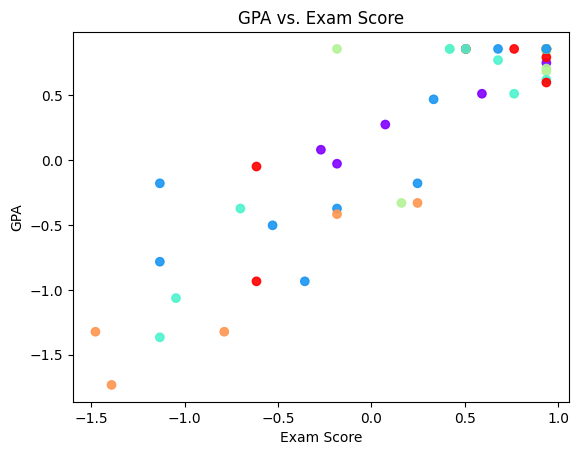

In [83]:
plt.scatter(X_samp["exam_score"], X_samp["previous_gpa"], c=kmeans_s.labels_, alpha=0.9, cmap="rainbow")
plt.xlabel("Exam Score")
plt.ylabel("GPA")
plt.title("GPA vs. Exam Score")
plt.show()

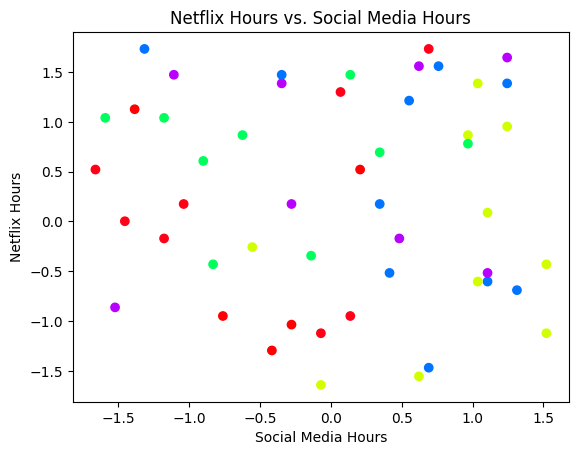

In [84]:
plt.scatter(X_samp["social_media_hours"], X_samp["netflix_hours"], c=kmeans_s.labels_, cmap="hsv")
plt.xlabel("Social Media Hours")
plt.ylabel("Netflix Hours")
plt.title("Netflix Hours vs. Social Media Hours")
plt.show()

In all the plots, the clusters are not very well-defined because far-away points are in the same cluster. That suggests this dataset is not very well-suited for K-means clustering. 

However, let's interpret the clusters that are fairly well-defined. In the GPA vs. exam anxiety score plot, the blue cluster contains students with a below-average exam anxiety score and a wide range of GPAs. The GPAs range from more than 0.5 standard deviations (SDs) above the mean to nearly 1 SD below the mean. So, students with a low exam anxiety score can have a wide range of GPAs, suggesting that exam anxiety score doesn't affect GPA. The red cluster contains students with a below-average exam anxiety score and a high GPA, suggesting that students who are less anxious in exams perform better in school. The green and turquoise clusters have students with a high exam anxiety score and a wide range of GPAs. Overall, we can say that exam anxiety and GPA are unrelated. That is promising because it shows that exam anxiety doesn't cause students to perform badly. If a student can't get help for their exam anxiety, it will not unfairly affect their academic performance.

In the GPA vs. exam score plot, the clusters are all over the place and not defined at all. That suggests no relationship between GPA and exam score. But there clearly is a relationship: as we saw previously, the correlation coefficient between the two features is about 0.93. That suggests k-means clustering is inaccurate for those two features.

In the Netflix hours vs. social media hours plot, the red cluster usually contains students with fewer social media hours, but some students have fewer Netflix hours and others have more Netflix hours. In the yellow-green cluster, most students have more social media hours but a wide range of Netflix hours, from low to high. In the green cluster, students have more Netflix hours but a wide range of social media hours. So, there's no relationship between Netflix use and social media use. 

## Hierarchical Clustering

In [85]:
def plot_hc(linkage, ax, cut=-np.inf):
    cargs = {'above_threshold_color':'black',
             'color_threshold':cut}
    hc = AgglomerativeClustering(n_clusters=None,
                distance_threshold=0,
                linkage=linkage.lower()).fit(X_samp)
    linkage_ = compute_linkage(hc)
    dendrogram(linkage_,
               ax=ax,
               leaf_font_size=10,
               **cargs)
    ax.set_title('%s Linkage' % linkage)
    labs = cut_tree(linkage_, n_clusters=6).reshape(-1)
    return labs

### Specific criteria 4 (part 2)

Question: Plot/Discussion: After clustering, which observations belong to the same cluster? Look at the underlying data and see what might be similar between them, and how these differ from observations in other clusters. How can the groups be interpreted?

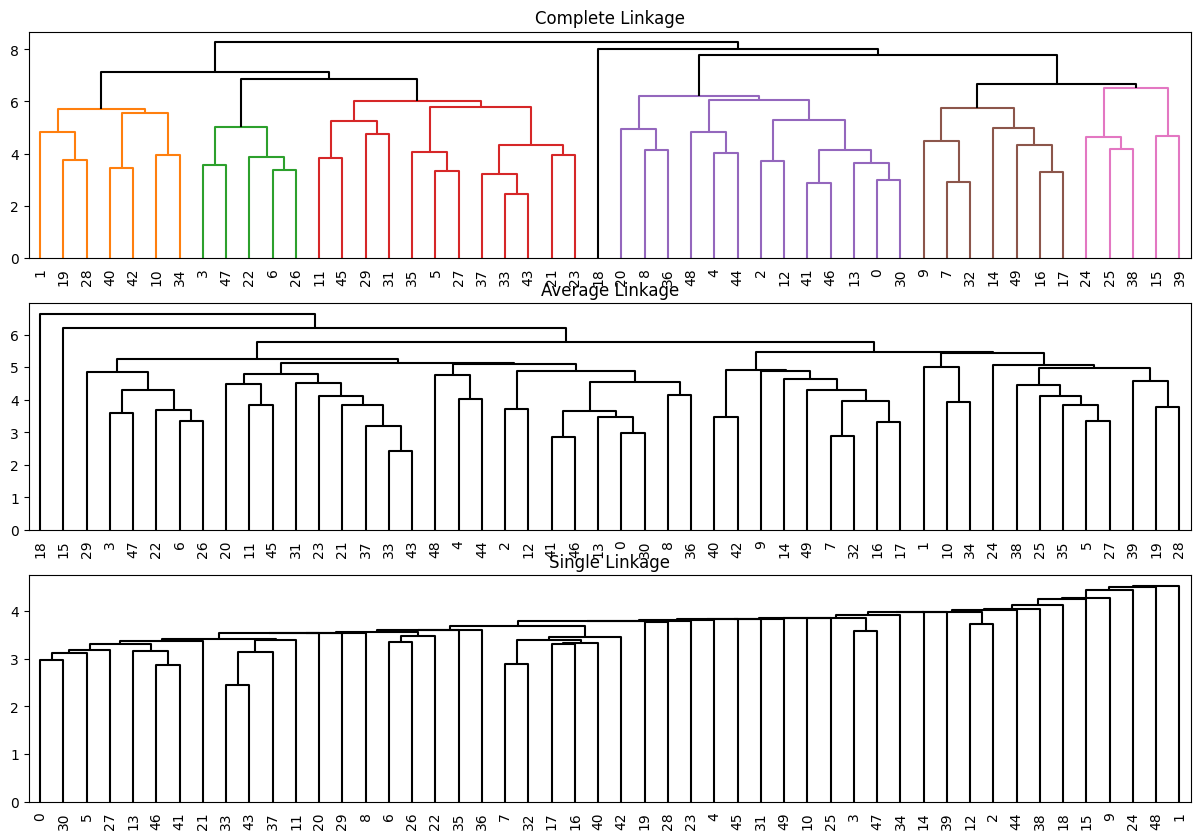

In [86]:
fig, axes = plt.subplots(3, 1, figsize=(15,10))
ax = axes[0]; hc_comp = plot_hc('Complete', ax, 6.6)
ax = axes[1]; hc_avg = plot_hc('Average', ax)
ax = axes[2]; hc_sing = plot_hc('Single', ax)

In order to look at similarities in our clusters, let's look at all the samples in the cluster highlighted in red.

In [87]:
X_samp.iloc[[11, 45, 29, 31, 35, 5, 27, 37, 33, 43, 21, 23]]

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,mental_health_rating,previous_gpa,stress_level,social_activity,screen_time,parental_support_level,motivation_level,exam_anxiety_score,time_management_score,exam_score
31266,1.600758,-0.585986,-0.139312,-0.344082,-0.575084,0.874070,-0.106219,-1.063896,0.761597,1.466762,-0.313943,0.529203,-1.216462,0.830286,1.651945,-1.047442
60684,1.600758,1.210311,0.344972,0.693994,0.099932,-0.557064,-0.470505,-1.366355,0.863995,0.293247,1.268306,-0.514890,0.178353,0.273617,1.267849,-1.133713
68613,0.265839,-0.136912,1.244357,1.386044,-0.661625,-0.557064,-2.135812,0.686045,-0.467180,-0.293511,0.836784,1.573295,-1.565166,0.830286,1.037392,0.936783
17657,1.333774,0.742592,-1.592164,1.040019,-1.348180,-0.148168,0.622353,0.858879,-1.491161,-0.880268,-0.026261,0.877233,-0.519054,0.830286,1.459897,0.505430
10857,1.333774,0.262265,0.690889,1.732070,-1.117405,-0.761512,0.310108,0.599628,0.198408,0.880004,1.340226,1.573295,0.875761,-0.839721,-0.230124,0.936783
66114,0.265839,-0.153694,-0.346862,1.386044,0.463403,0.533324,1.663170,0.858879,0.352005,0.880004,0.477182,1.573295,0.178353,0.273617,-1.612869,0.936783
57586,-0.268128,-1.134855,0.206605,0.520981,0.076855,-0.148168,0.414189,0.275565,-0.569578,1.466762,-0.242023,1.573295,-0.170351,0.830286,0.230791,0.074076
29554,0.532823,0.262265,-0.623596,0.867006,-0.984710,-0.284467,0.153985,0.858879,0.812796,1.466762,0.189500,0.181172,-1.565166,0.830286,1.383078,0.419159
68860,0.532823,-0.087015,0.967623,0.780500,0.365323,0.465175,0.726434,0.621233,0.096010,0.880004,0.836784,-1.558982,-1.216462,0.830286,0.960573,0.936783
2775,-0.268128,0.312162,-0.900330,0.607487,0.544174,0.397026,1.350925,0.513212,0.608000,0.293247,0.189500,-1.558982,-1.565166,0.830286,0.960573,0.764242


Just by looking at the table, we can immediately observe similarities between values in multiple rows. For example, the first two rows have the exact same scaled age value. Rows 2 and 3 have the same sleep_hours score, and rows 4, 6, and 8 all have the same scaled previous_gpa score. Most rows also display the exact same exam_anxiety score, and even two of the outlier rows have the same score as each other. The biggest factor uniting these samples is the shared exam_anxiety score, but in general, they all share common scores across other categories as well, which is most likely why they are grouped together. Now let's look at the cluster highlighted in pink and see what is in common.

In [88]:
X_samp.iloc[[24, 25, 38, 15, 39]]

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,mental_health_rating,previous_gpa,stress_level,social_activity,screen_time,parental_support_level,motivation_level,exam_anxiety_score,time_management_score,exam_score
11297,1.066790,1.013412,-1.177064,-0.171070,0.134548,-0.420765,0.049903,0.858879,0.352005,1.466762,-0.026261,-1.210952,1.573168,-1.953059,1.613535,0.936783
10934,1.066790,0.012780,0.068238,1.299538,1.588430,0.601473,0.206026,0.858879,-1.593559,1.466762,0.441221,0.181172,1.224465,-1.396390,-0.767858,0.764242
39029,0.265839,2.377229,-1.661348,0.520981,0.699947,0.397026,1.663170,0.794066,-0.774374,1.466762,1.340226,1.573295,0.875761,-0.839721,0.192381,0.936783
74413,-0.001145,3.489541,0.621706,-1.555171,-0.332771,-0.011870,-0.262342,0.858879,-0.159985,-1.467026,2.023470,1.573295,0.875761,-0.839721,0.307610,0.677971
17650,0.532823,1.643978,-0.070129,-1.122639,-1.180869,0.260727,0.622353,0.858879,-2.054350,-0.293511,0.836784,-0.862921,0.527057,-0.283052,-1.497640,0.936783


This group shares similar social_activity and exam_score levels. We also observe that four of five rows share the same previous_gpa score. Overall, this group shows less social media and netflix hours than the red group. This group also reports higher motivation levels and lower exam anxiety. Although a lot of the common rows have values shared across the red cluster as well, the overall patterns of these groups seem to be different.

Below is a confusion matrix comparing K-means classification to hierarchical classification.

In [89]:
pd.crosstab(pd.Series(hc_comp, name='HClust'),
            pd.Series(kmeans_s.labels_, name='K-means'))

K-means,0,1,2,3,4,5
HClust,,,,,,
0,0,0,1,6,6,0
1,2,2,0,0,0,3
2,2,0,0,3,0,0
3,1,0,8,1,1,1
4,0,8,0,0,0,4
5,0,0,0,0,1,0


Our confusion matrix shows us that our K-means and hierarchical methods have somewhat dissimilar ideas for clustering, as most classes in our hierarchical classifications are divided into two or three different classifications on the K-means methods (with the exception of hierarchical group 5, which only has one instance). If we wanted to look at explicit matches, only 3 out of 50 samples had the same class number across both classification methods.

# Conclusion

**PCA**

Our findings from PCA were that GPA and exam score are strongly positively correlated. Also, students with a high exam score have a low exam anxiety score. Students who had more motivation or studied for more hours per day, performed better on exams. Interestingly, students who had more screen time performed better on exams. The implications of this are that anxiety has a measurable negative impact on exam performance, which means it's crucial for students to address their anxiety. Motivation is also key for exam performance, so  Hopefully, our work could be used to motivate colleges to hire more psychologists and provide other resources for students with anxiety. Future researchers could also branch off our work to see what factors affect motivation, and that could benefit student well-being. For instance, maybe students with tense family relationships or with less social interaction are less motivated for school.

**k-Means Clustering**

When looking at k-means clustering we saw poor clustering that was probably caused from many points being equally far spaced apart from one another, suggesting this dataset is a poor candidate for k-means. The findings that we did see were that students who had varying levels of exam anxiety did not have any impact on their chances for academic success. This is the opposite of the finding we had from PCA, but we think that's because this dataset is not a good choice for K-means clustering. Interestingly, we also saw very limited results when comparing exam scoring with GPA as well. That is also the opposite of our finding from PCA. In all the plots, the clusters are not very well-defined because far-away points are in the same cluster. That suggests this dataset is not very well-suited for K-means clustering. So, we cannot really trust these findings.

**Hierarchical Clustering**

When looking at hierarchical clustering we saw groupings of social activity and exam score, as well as social media and Netflix hours, and finally, exam anxiety and exam score were also grouped together. An interpretation of this is that people who report higher levels of social activity also perform better on exams. This indicates that perhaps forming study groups and promoting pro-social behavior with other people helps with consistent study habits. Now, colleges can put more effort into social activities like clubs, icebreakers, and movie nights. That could help academic performance.

Social media and Netflix hours were also correlated indicating that people tend to spend roughly the same amount of 'down-time' performing similar amounts of activities, but these do not seem to contribute to academic success. 

Finally, exam anxiety and exam performance were also correlated, indicating the connection between how people feel about an exam and their performance on it. One group in particular denoted as the "red group" in clustering is particularly of note. this group had a positive corelation of hours studied, previous gpa, reported anxiety, social activity, and motivation levels with a negative component of social media and Netflix, indicating that a person who has one or more of these a positive correlation groups are more likely to have the other and will also predict academic success.

There is a long-standing stereotype that activities like social media and Netflix contribute negatively to academic performance. Our findings show that's not true. Perhaps students find those activities relaxing, allowing them to recover from the stress of school and do better in school. Future researchers could use our work to further demonstrate that. They could also compare the impact of electronic vs. non-electronic activities (for instance, Netflix vs. board games).

# References

\[1\] Kumar, Aryan. “Student Habits and Academic Performance Dataset.” Kaggle.com, www.kaggle.com/datasets/aryan208/student-habits-and-academic-performance-dataset. Accessed 19 May 2025.

\[2\] Sci-Kit Learn Developers. “PCA.” Scikit-Learn API Reference, scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html. Accessed 23 May 2025.